In [13]:
import pandas as pd, numpy as np


# Aggregation and Grouping

For convenience, let's redesign the `display()` function from the previous section

In [14]:
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)


For this walkthrough we'll use the Planets Dataset from the seaborn package

In [15]:
import seaborn as sns
planets=sns.load_dataset('planets')


## Simple Aggregation in Pandas

Similar to what we saw with data aggregation in Numpy, `Series` also return a single value

In [16]:
rng=np.random.RandomState(42)
ser=pd.Series(rng.rand(5))
ser

0    0.374540
1    0.950714
2    0.731994
3    0.598658
4    0.156019
dtype: float64

In [17]:
ser.sum(),  ser.mean(), ser.std()

(2.811925491708157, 0.5623850983416314, 0.30874824961862174)

For Dataframes, the aggregate methods are returned columnwise

In [18]:
df=pd.DataFrame({'A': rng.rand(5),
                   'B': rng.rand(5)})
df.mean()

A    0.477888
B    0.443420
dtype: float64

Specifying the axis can give you the same aggregate about a different axis

In [19]:
df.mean(axis=1)#row-wise average

0    0.088290
1    0.513997
2    0.849309
3    0.406727
4    0.444949
dtype: float64

In addition to all the common aggregates implemented in Numpy, Pandas provides a very convinient method `describe()` that computes several common aggregates for each column and returns the result. Let's use this on the Planets data, for now dropping rows with missing values.

In [20]:
planets.dropna().describe()

,number,orbital_period,mass,distance,year
count,498.00000,498.000000,498.000000,498.000000,498.000000
mean,1.73494,835.778671,2.509320,52.068213,2007.377510
std,1.17572,1469.128259,3.636274,46.596041,4.167284
min,1.00000,1.328300,0.003600,1.350000,1989.000000
25%,1.00000,38.272250,0.212500,24.497500,2005.000000
50%,1.00000,357.000000,1.245000,39.940000,2009.000000
75%,2.00000,999.600000,2.867500,59.332500,2011.000000
max,6.00000,17337.500000,25.000000,354.000000,2014.000000


Methods and functions like these can be very handy to understand the basic properties of the dataset.

The table below summarizes some built-in Pandas aggregation functions

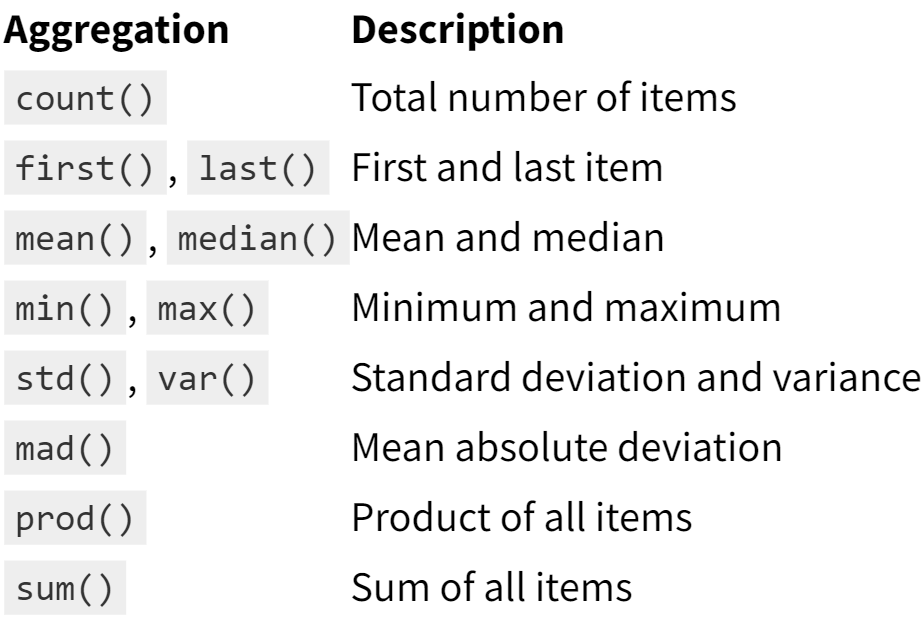

Although, simple aggregate functions can come handy, We can take data summarization to a next level by summarization of our data using the GroupBy functionality

## GroupBy: Split-Apply-Combine

Say you want to gain knowledge about the dataset subject to certain constraints. This is where the `GroupBy` function comes handy.

### Split - apply - combine

This process of split, apply(or aggregation), combine can be illustrated as follows

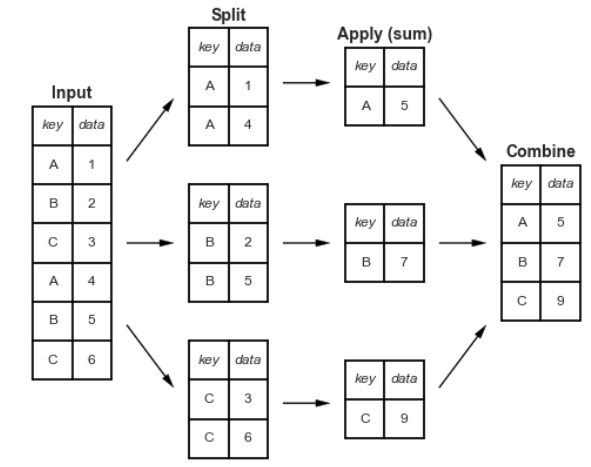

**Split**: Consists of breaking and grouping the `DataFrame` depending on a certain key.
**Apply**: Computing the aggregate/ Transforming/ Filtering within each individual group
**Combine**: Merging the result into an output array

In [21]:
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data': range(6)}, columns=['key', 'data'])
df


,key,data
0,A,0
1,B,1
2,C,2
3,A,3
4,B,4
5,C,5


In [22]:
df.groupby('key')

Notice how the product of the `groupby` method is not a dataframe but a DataFrameGroupBy object. This object is like an intermediatory before further calculations are executed. This "lazy evaluation" approadh means that the aggregates can be implemented very efficiently in a way that's almost transparent to the user

In [24]:
df.groupby('key').sum()

,data
key,
A,3
B,5
C,7


The `sum()` method is just one of the many aggregates that you can implement.

### The `GroupBy` Object

This object can be treated as a collection of DataFrames that let's us do difficult calculations under the hood

#### Column indexing

In [25]:
planets

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300000,7.10,77.40,2006
1,Radial Velocity,1,874.774000,2.21,56.95,2008
2,Radial Velocity,1,763.000000,2.60,19.84,2011
3,Radial Velocity,1,326.030000,19.40,110.62,2007
4,Radial Velocity,1,516.220000,10.50,119.47,2009
...,...,...,...,...,...,...
1030,Transit,1,3.941507,NaN,172.00,2006
1031,Transit,1,2.615864,NaN,148.00,2007
1032,Transit,1,3.191524,NaN,174.00,2007
1033,Transit,1,4.125083,NaN,293.00,2008


The `GroupBy` object supports column indexing in the same way as the `DataFrame`, and returns a modified `GroupBy` object. For example:

In [34]:
planets.groupby('method')

In [33]:
planets.groupby('method')['orbital_period']

Notice how the two objects are different (`DataFrameGroupBy` and `SeriesGroupBy`)<n>
Here we've selected a specific colomn by indexing the `GroupBy` method. Just like indexing a specific column in a DataFrame returns a Series, Indexing a `DataFrameGroupBy` returns a `SeriesGroupBy`.


In [36]:
planets.groupby('method')['orbital_period'].median()

method
Astrometry                         631.180000
Eclipse Timing Variations         4343.500000
Imaging                          27500.000000
Microlensing                      3300.000000
Orbital Brightness Modulation        0.342887
Pulsar Timing                       66.541900
Pulsation Timing Variations       1170.000000
Radial Velocity                    360.200000
Transit                              5.714932
Transit Timing Variations           57.011000
Name: orbital_period, dtype: float64

This gives an idea of the general scale of orbital periods (in days) that each method is sensitive to.


#### Iteration over Groups